# **Capstone Project - HerbPlants**


HerbPlants adalah proyek machine learning berbasis computer vision yang dirancang untuk mengenali tanaman herbal Indonesia melalui citra visual. Model dikembangkan dengan pendekatan transfer learning menggunakan arsitektur MobileNetV2, yang ringan dan optimal untuk implementasi di perangkat rendah daya seperti browser.

## Import Library

Pada tahap ini dilakukan instalasi library `tensorflowjs`, yaitu pustaka resmi dari TensorFlow yang memungkinkan model machine learning dijalankan langsung di browser menggunakan JavaScript. Library ini sangat penting karena proyek HerbPlants dikembangkan sebagai aplikasi Progressive Web App (PWA), sehingga model yang telah dilatih dengan TensorFlow di Python perlu dikonversi ke format yang kompatibel dengan browser.

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import os
import random
import shutil
import pathlib
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2, ResNet50
from tensorflow.keras.preprocessing import image

Tahap ini memuat seluruh library dan modul yang dibutuhkan dalam pengembangan model klasifikasi gambar untuk proyek HerbPlants. Beberapa kelompok library yang digunakan meliputi:

- **Library dasar Python** seperti `os`, `random`, `shutil`, dan `pathlib` untuk pengelolaan file dan direktori.
- **Pustaka manipulasi data** seperti `numpy` dan `pandas`, serta `matplotlib` untuk visualisasi.
- **Scikit-learn** digunakan untuk pembagian dataset (`train_test_split`).
- **Pillow (PIL)** dipakai untuk memproses gambar.
- **TensorFlow dan Keras** sebagai core framework untuk membangun, melatih, dan menyimpan model deep learning. Termasuk di dalamnya layer-layer arsitektur (Conv2D, Dense, Dropout, dsb), mekanisme callback (EarlyStopping, ModelCheckpoint), serta image preprocessing (`ImageDataGenerator`).
- Juga disertakan **pre-trained models** dari `tensorflow.keras.applications`, seperti `MobileNetV2`, `EfficientNetV2B0`, dan `ResNet50` sebagai opsi untuk eksperimen transfer learning.

Semua library ini akan digunakan bertahap sepanjang proses preprocessing data, pembuatan model, pelatihan, evaluasi, dan penyimpanan model dalam format yang dapat digunakan di aplikasi web.

## Dataset

### Load Dataset

Pada tahap ini, dataset gambar tanaman herbal Indonesia diunduh dari repositori GitHub menggunakan perintah `wget`. Dataset ini merupakan kumpulan gambar tanaman obat yang telah dikurasi dan digunakan sebagai sumber data utama untuk melatih model klasifikasi. Dataset disimpan dalam format `.zip` dan berisi gambar-gambar berbagai jenis tanaman herbal lokal Indonesia.

In [ ]:
!wget https://github.com/Salmanim20/indomedicinalplant/raw/main/Indonesia%20Medicinal%20Plant%20Dataset.zip

--2025-06-11 15:28:14--  https://github.com/Salmanim20/indomedicinalplant/raw/main/Indonesia%20Medicinal%20Plant%20Dataset.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Salmanim20/indomedicinalplant/main/Indonesia%20Medicinal%20Plant%20Dataset.zip [following]
--2025-06-11 15:28:14--  https://raw.githubusercontent.com/Salmanim20/indomedicinalplant/main/Indonesia%20Medicinal%20Plant%20Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94022454 (90M) [application/zip]
Saving to: ‘Indonesia Medicinal Plant Dataset.zip’

Indonesia Medicinal 100%[===================>]  89.67M   176MB/s 

In [ ]:
!mkdir -p "dataset/Indonesia Medicinal Plant Dataset"
!unzip -q "Indonesia Medicinal Plant Dataset.zip" -d "dataset/Indonesia Medicinal Plant Dataset"

Setelah proses pengunduhan selesai, file ZIP yang berisi dataset perlu diekstrak agar struktur folder dan file gambar dapat diakses oleh pipeline pelatihan.


In [ ]:
base_path = "dataset/Indonesia Medicinal Plant Dataset"

image_paths = []
labels = []

for label in os.listdir(base_path):
    label_folder = os.path.join(base_path, label)
    if os.path.isdir(label_folder):
        for file_name in os.listdir(label_folder):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(label_folder, file_name))
                labels.append(label)

Pada tahap ini, dilakukan proses pembacaan struktur folder dari dataset yang telah diekstrak. Setiap subfolder di dalam direktori utama (`base_path`) diasumsikan sebagai satu kelas tanaman herbal, di mana nama folder merepresentasikan label dari gambar-gambar yang ada di dalamnya.

Proses dilakukan dengan membaca seluruh nama file gambar (dengan ekstensi .jpg, .jpeg, atau .png) dan mencatat path lengkapnya ke dalam list `image_paths`. Pada saat yang sama, label dari masing-masing gambar juga disimpan ke dalam list `labels` berdasarkan nama folder induknya.

Tahap ini merupakan fondasi penting untuk membangun dataset terstruktur yang siap diproses lebih lanjut untuk pelatihan model klasifikasi.

In [ ]:
df = pd.DataFrame({
    'image': image_paths,
    'label': labels
})

df.head()

,image,label
0,dataset/Indonesia Medicinal Plant Dataset/Euph...,Euphorbia Tirucalli (Patah Tulang)
1,dataset/Indonesia Medicinal Plant Dataset/Euph...,Euphorbia Tirucalli (Patah Tulang)
2,dataset/Indonesia Medicinal Plant Dataset/Euph...,Euphorbia Tirucalli (Patah Tulang)
3,dataset/Indonesia Medicinal Plant Dataset/Euph...,Euphorbia Tirucalli (Patah Tulang)
4,dataset/Indonesia Medicinal Plant Dataset/Euph...,Euphorbia Tirucalli (Patah Tulang)


Setelah seluruh path gambar dan label tanaman herbal berhasil diekstrak, langkah berikutnya adalah menyusunnya ke dalam struktur DataFrame menggunakan `pandas`. Hal ini dilakukan agar data lebih mudah diinspeksi, dianalisis, dan diproses di tahap selanjutnya.

Setiap baris dalam DataFrame berisi dua kolom utama:
- `image`: berisi path lengkap menuju file gambar.
- `label`: berisi nama kelas tanaman herbal yang sesuai, berdasarkan nama folder.


In [ ]:
class_counts = df['label'].value_counts()
print(class_counts)

label
Euphorbia Tirucalli (Patah Tulang)      100
Nepeta Cataria (Catnip)                 100
Artocarpus Integer (Nangka Cempedak)    100
Jasminum Sambac (Melati)                100
Caladium Cicolor (Keladi)               100
                                       ... 
Plectranthus Scutellarioides (Miana)    100
Pluchea Indica (Beluntas)               100
Physalis Angulata (Ceplukan)            100
Melaleuca Leucadendra (Kayu Putih)      100
Prunus Domestica (Plum)                 100
Name: count, Length: 100, dtype: int64


Langkah ini bertujuan untuk mengetahui jumlah gambar pada setiap kelas tanaman herbal dalam dataset. Dengan menggunakan fungsi `value_counts()` dari `pandas`, kita bisa melihat apakah dataset memiliki distribusi yang seimbang antar label.

Hasil analisis menunjukkan bahwa setiap kelas memiliki jumlah data yang sama, yaitu 100 gambar per label. Hal ini mengindikasikan bahwa dataset telah terstruktur dengan baik dan siap digunakan untuk pelatihan model klasifikasi tanpa perlu melakukan balancing tambahan.

In [ ]:
df['label'].unique()

array(['Euphorbia Tirucalli (Patah Tulang)', 'Nepeta Cataria (Catnip)',
       'Artocarpus Integer (Nangka Cempedak)', 'Jasminum Sambac (Melati)',
       'Caladium Cicolor (Keladi)', 'Melia Azedarach (Mindi)',
       'Hydrocotyle Sibthorpioides (Semanggi Gunung)',
       'Ruta Angustifolia (Inggu)', 'Raulvolvia Serpentina (Pule Pandak)',
       'Eupatorium Triplinerve (Prasman)', 'Centella Asiatica (Pegagan)',
       'Orthosiphon Spicatus (Kumis Kucing)',
       'Ocimum Basilicum (Kemangi)', 'Annona Muricata (Sirsak)',
       'Phytolacca Americana (Mrico Kepyar)',
       'Morinda Citrifolia (Mengkudu)', 'Peperomia Pellucida (Suruhan)',
       'Michelia Alba (Kembang Kantil)', 'Jatropa Multifida (Betadin)',
       'Pleomele Angustifolia (Suji)', 'Kaempferia Galanga (Kencur)',
       'Cymbopogon Nardus (Serai)',
       'Tithonia Diversifolia (Daun Insulin)',
       'Borreria Hispida (Gempur Batu)', 'Pouteria Caimito (Abiu)',
       'Ocimum Americanum (Selasih)', 'Curcuma Domestica (Kunyi

Untuk memastikan variasi kelas yang ada dalam dataset, langkah ini dilakukan untuk menampilkan seluruh label unik dari kolom `label`. Setiap label merepresentasikan nama spesies tanaman herbal lokal Indonesia, lengkap dengan nama ilmiah dan sebutan lokalnya dalam tanda kurung. Hasilnya menunjukkan bahwa terdapat **100 kelas tanaman herbal** yang berbeda, masing-masing terdiri dari 100 gambar.

## Data Preprocessing

### Split Dataset

Sebelum data digunakan untuk melatih model, dataset perlu dibagi menjadi tiga bagian utama: data training, data validation, dan data testing. Tujuannya adalah untuk memastikan proses pelatihan dapat berjalan dengan baik sekaligus menjaga objektivitas evaluasi model.

Dalam tahap ini:
- **80% data dialokasikan untuk training**, yang digunakan langsung dalam proses pembelajaran model.
- **20% sisanya dibagi rata** menjadi 10% untuk validation dan 10% untuk testing. Data validation membantu memantau performa model selama pelatihan dan mencegah overfitting, sementara data testing digunakan untuk evaluasi akhir setelah model selesai dilatih.

Distribusi akhir yang dihasilkan:
- **Training**: 8000 data
- **Validation**: 1000 data
- **Testing**: 1000 data

In [ ]:
train_df, val_test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)
val_df, test_df = train_test_split(val_test_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [ ]:
print('Data Training Shape    : ', len(train_df))
print('Data Validation Shape  : ', len(val_df))
print('Data Testing Shape     : ', len(test_df))

Data Training Shape    :  8000
Data Validation Shape  :  1000
Data Testing Shape     :  1000


### Data Augmentation

Agar model dapat belajar dengan lebih general dan tidak mudah overfitting, dilakukan proses **data augmentation**. Proses ini bertujuan untuk memperkaya variasi visual gambar yang dimasukkan ke model tanpa menambah jumlah data secara manual.

Pertama, digunakan `ImageDataGenerator` dari Keras untuk menormalisasi nilai piksel gambar ke rentang [0,1] dengan `rescale=1.0/255`. Kemudian data training, validation, dan testing diproses melalui metode `flow_from_dataframe()` agar pipeline dapat membaca gambar langsung dari DataFrame yang telah disusun sebelumnya. Citra ditargetkan ke ukuran 224x224 piksel, yang disesuaikan dengan input standar model MobileNetV2.

Pada bagian akhir, disiapkan strategi augmentasi tambahan menggunakan `Sequential` dari `keras.layers`, dengan dua transformasi sederhana yaitu:
- **RandomZoom(0.1)** untuk memperbesar bagian gambar secara acak,
- **RandomFlip("horizontal_and_vertical")** untuk membalik gambar secara horizontal maupun vertikal.

Augmentasi ini akan diterapkan dengan tujuan agar model bisa lebih robust terhadap variasi sudut pandang dan skala objek pada citra.

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_datagen = datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = datagen.flow_from_dataframe(
    val_df,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8000 validated image filenames belonging to 100 classes.
Found 1000 validated image filenames belonging to 100 classes.
Found 1000 validated image filenames belonging to 100 classes.


In [ ]:
data_augmentation = Sequential([
    layers.RandomZoom(0.1),
    layers.RandomFlip("horizontal_and_vertical")
])

## Modelling

In [ ]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Langkah pertama dalam tahap pemodelan adalah memuat model arsitektur **MobileNetV2** yang sudah dilatih sebelumnya di dataset ImageNet. MobileNetV2 dipilih karena merupakan model convolutional neural network (CNN) yang ringan, cepat, dan efisien, sehingga cocok untuk diimplementasikan dalam aplikasi berbasis browser seperti Progressive Web App (PWA).

Berikut konfigurasi yang digunakan:
- `input_shape=(224, 224, 3)`: Ukuran input citra yang sesuai dengan format standar MobileNetV2.
- `include_top=False`: Bagian fully-connected layer terakhir dari model asli tidak disertakan agar kita dapat menambahkan layer klasifikasi sesuai jumlah kelas kita sendiri (100 kelas tanaman herbal).
- `weights='imagenet'`: Menggunakan bobot hasil pretraining dari dataset ImageNet, agar model dapat memanfaatkan pengetahuan fitur visual umum.
- `pooling='avg'`: Menggunakan global average pooling sebagai output sebelum masuk ke classifier, untuk mereduksi dimensi secara efisien.

In [ ]:
for layer in pre_trained_model.layers :
    print(layer.name)

input_layer
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_ex

Pada tahap ini, seluruh layer dari model **MobileNetV2** ditampilkan menggunakan perulangan `for` untuk mengetahui struktur internal dari model pretrained. Tujuannya adalah :
- Memahami arsitektur secara rinci, mulai dari convolutional layer, batch normalization, hingga activation function.
- Menentukan posisi di mana transfer learning atau fine-tuning akan dilakukan.
- Mengidentifikasi layer terakhir dari MobileNetV2 (biasanya `global_average_pooling2d`) yang akan menjadi titik koneksi ke model klasifikasi yang kita kembangkan.

Dengan menampilkan semua nama layer, kita bisa mengontrol layer mana yang akan dibekukan (freeze) dan mana yang akan dilatih ulang (trainable), sehingga proses transfer learning menjadi lebih terarah dan efisien.

In [ ]:
pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

**Fine-Tuning Model (Selective Layer Training)**

Pada bagian ini, dilakukan proses **fine-tuning** terhadap model MobileNetV2. Secara khusus, hanya layer-layer tertentu dari bagian akhir arsitektur yang dibuat dapat dilatih (trainable), yaitu dimulai dari layer bernama `'block_16_expand'` hingga layer terakhir.

Langkah ini dilakukan dengan pendekatan sebagai berikut:

* `pre_trained_model.trainable = True`: mengaktifkan mode pelatihan pada seluruh layer model.
* Kemudian, melalui iterasi seluruh layer, disetel bahwa hanya layer mulai dari `'block_16_expand'` ke bawah yang diaktifkan (trainable), sedangkan layer sebelumnya dibekukan (non-trainable).
* Hal ini berguna untuk **mempertahankan fitur dasar** yang sudah dipelajari MobileNetV2 dari dataset ImageNet, sambil tetap **menyesuaikan representasi akhir** agar lebih sesuai dengan data tanaman herbal Indonesia.

Strategi ini merupakan praktik umum dalam transfer learning untuk mempercepat pelatihan, mengurangi overfitting, serta memanfaatkan kekuatan representasi visual dari model pralatih sambil menyesuaikan bagian akhir model dengan konteks domain yang lebih spesifik.


In [ ]:
model = models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    data_augmentation,
    pre_trained_model,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(100, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pada bagian ini, seluruh arsitektur model dibangun menggunakan pendekatan **Sequential API** dari Keras. Rangkaian layer dirancang untuk menggabungkan proses augmentasi data, ekstraksi fitur dari model pralatih, hingga klasifikasi akhir ke dalam 100 kelas tanaman herbal.

Rangkaian layer terdiri atas:

1. **Input Layer**
   Menentukan bentuk input gambar sebagai `(224, 224, 3)` yang sesuai dengan standar MobileNetV2 dan ukuran input dataset.

2. **Data Augmentation**
   Layer augmentasi yang telah didefinisikan sebelumnya disisipkan di awal model untuk memberikan variasi visual pada gambar selama pelatihan, sehingga model lebih tahan terhadap noise data dunia nyata.

3. **Pre-trained Model (MobileNetV2)**
   Digunakan sebagai feature extractor. Model ini tidak di-train sepenuhnya, hanya bagian atas (dari `block_16_expand`) yang diaktifkan untuk pelatihan ulang.

4. **Dense Layer (256 unit)**
   Layer fully connected dengan aktivasi ReLU yang membantu dalam proses klasifikasi dan pembelajaran pola kompleks setelah fitur diekstraksi.

5. **Dropout Layer (rate 0.3)**
   Digunakan sebagai teknik regularisasi untuk mencegah overfitting dengan cara menghilangkan sejumlah unit secara acak saat pelatihan.

6. **Output Layer (100 unit, Softmax)**
   Layer akhir dengan 100 neuron dan aktivasi softmax digunakan untuk mengklasifikasikan gambar ke dalam 100 kelas tanaman herbal berdasarkan probabilitas tertinggi.

Kombinasi arsitektur ini dirancang untuk efisiensi dan akurasi tinggi dalam lingkungan terbatas (browser via TensorFlow\.js), tanpa mengorbankan kemampuan generalisasi terhadap data baru.


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,611,620 (9.96 MB)

 Trainable params: 1,239,716 (4.73 MB)

 Non-trainable params: 1,371,904 (5.23 MB)

Hasil `model.summary()` menampilkan struktur lengkap dari arsitektur model klasifikasi yang dibangun menggunakan pendekatan transfer learning. Model terdiri dari total **2.611.620 parameter**, dengan **1.239.716** di antaranya bersifat dapat dilatih (trainable), sementara sisanya merupakan parameter tetap (non-trainable) dari model pralatih MobileNetV2.

Komponen utama model meliputi:

* **Input Layer**: Menerima citra berukuran `(224, 224, 3)` sebagai format standar untuk proses ekstraksi fitur.
* **MobileNetV2**: Berfungsi sebagai feature extractor utama, menggunakan bobot pralatih dari ImageNet. Beberapa lapisan terakhir dibuka kembali untuk proses fine-tuning agar model dapat beradaptasi dengan data tanaman herbal lokal.
* **Dense Layer** dengan 256 neuron dan fungsi aktivasi ReLU: Memberikan kemampuan klasifikasi tambahan di atas fitur yang telah diekstraksi.
* **Dropout Layer**: Diterapkan untuk mengurangi risiko overfitting selama pelatihan dengan menghilangkan beberapa koneksi neuron secara acak.
* **Output Layer**: Menghasilkan prediksi untuk **100 kelas tanaman herbal lokal**, menggunakan fungsi aktivasi softmax untuk mengembalikan distribusi probabilitas.

Struktur ini dirancang agar tetap ringan dan efisien, sehingga ideal untuk diimplementasikan sebagai aplikasi berbasis web (PWA) tanpa mengorbankan akurasi dan performa.

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Setelah arsitektur model selesai disusun, tahap selanjutnya adalah melakukan proses kompilasi. Kompilasi ini bertujuan untuk mengonfigurasi proses pelatihan model dengan menetapkan algoritma optimisasi, fungsi loss, serta metrik evaluasi yang digunakan.

Pada proyek ini, digunakan **optimizer Adam** dengan nilai *learning rate* sebesar `0.0001`. Pemilihan Adam didasarkan pada performanya yang stabil dan efisien dalam mempercepat proses konvergensi, terutama pada jaringan saraf dalam dengan jumlah parameter yang besar.

Sebagai **fungsi loss**, digunakan `categorical_crossentropy` karena model ini memecahkan permasalahan klasifikasi multikelas, di mana label target memiliki format kategorikal (bukan numerik tunggal). Fungsi loss ini berfungsi untuk mengukur perbedaan antara probabilitas hasil prediksi dengan label kelas yang sebenarnya.

Untuk **metrik evaluasi**, digunakan `accuracy` guna memantau sejauh mana model mampu mengklasifikasikan gambar ke dalam kelas yang benar. Nilai akurasi ini akan ditampilkan selama proses pelatihan dan validasi, dan menjadi indikator utama dalam mengevaluasi performa model.

Kompilasi ini merupakan tahap krusial sebelum model dilatih, karena menentukan bagaimana model akan belajar dari data dan bagaimana hasilnya akan diukur secara kuantitatif.


In [ ]:
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

early_stopping = [
    EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0001, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1)
]

**Callback: ModelCheckpoint, EarlyStopping, dan ReduceLROnPlateau**

Untuk memastikan proses pelatihan model berjalan secara optimal dan efisien, digunakan beberapa strategi callback dalam bentuk `ModelCheckpoint`, `EarlyStopping`, dan `ReduceLROnPlateau`.

1. **ModelCheckpoint**

Callback ini bertugas menyimpan bobot model terbaik selama proses pelatihan. Model terbaik diidentifikasi berdasarkan nilai terkecil dari *validation loss* (`val_loss`). Parameter `save_best_only=True` memastikan hanya model dengan performa terbaik yang disimpan ke dalam file `'best_model.keras'`. Hal ini penting untuk mencegah penggunaan model yang mengalami overfitting di akhir pelatihan.

2. **EarlyStopping**

Fungsi `EarlyStopping` digunakan untuk menghentikan pelatihan secara dini apabila tidak terjadi peningkatan signifikan pada metrik `val_accuracy` dalam lima epoch berturut-turut (`patience=5`). Nilai `min_delta=0.0001` menunjukkan batas minimum perbaikan yang dianggap signifikan. Dengan `restore_best_weights=True`, model akan secara otomatis mengembalikan bobot ke kondisi terbaik sebelum performa menurun. Hal ini bertujuan menghindari pemborosan waktu dan sumber daya akibat pelatihan yang tidak lagi membawa peningkatan performa.

3. **ReduceLROnPlateau**

Callback `ReduceLROnPlateau` berfungsi untuk menyesuaikan *learning rate* secara dinamis jika tidak ada perbaikan pada `val_loss` dalam dua epoch berturut-turut. Penurunan *learning rate* dilakukan sebesar 20% dari nilai sebelumnya (`factor=0.2`). Pendekatan ini membantu model untuk keluar dari *local minima* dan meningkatkan peluang konvergensi yang lebih baik.

Penggunaan ketiga callback ini secara bersamaan memberikan kontrol yang lebih baik terhadap proses pelatihan dan mencegah overfitting, stagnasi, serta efisiensi waktu dan sumber daya komputasi.

In [ ]:
history = model.fit(
    train_datagen,
    steps_per_epoch=len(train_datagen),
    epochs=100,
    validation_data=val_datagen,
    validation_steps=len(val_datagen),
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - accuracy: 0.0831 - loss: 4.3209 - val_accuracy: 0.2580 - val_loss: 3.2472 - learning_rate: 1.0000e-04
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.3981 - loss: 2.5635 - val_accuracy: 0.3710 - val_loss: 2.5897 - learning_rate: 1.0000e-04
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5419 - loss: 1.8064 - val_accuracy: 0.4680 - val_loss: 2.1521 - learning_rate: 1.0000e-04
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.6312 - loss: 1.4457 - val_accuracy: 0.5310 - val_loss: 1.7815 - learning_rate: 1.0000e-04
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.6844 - loss: 1.1817 - val_accuracy: 0.5370 - val_loss: 1.7420 - learning_rate: 1.0000e-04
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.7483 - loss: 0.9863 - val_accuracy: 0.6270 - val_loss: 1.3671 - learning_rate: 1.0000e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 8

Model dilatih menggunakan metode `model.fit()` dengan dataset yang telah melalui proses augmentasi dan dibagi ke dalam tiga bagian: training, validation, dan testing. Pelatihan dilakukan selama maksimum **100 epoch**, namun dengan pengaturan *callback* berupa **EarlyStopping**, pelatihan akan dihentikan lebih awal jika tidak terdapat peningkatan pada metrik validasi.

Parameter `steps_per_epoch` dan `validation_steps` disesuaikan dengan jumlah batch dalam `train_datagen` dan `val_datagen`, sehingga seluruh data pada masing-masing subset digunakan secara optimal dalam setiap epoch. Penggunaan `callbacks=[checkpoint, early_stopping]` memberikan kontrol terhadap dinamika pelatihan dan menjamin bahwa model terbaik (berdasarkan nilai `val_loss` terendah) akan disimpan otomatis, sementara pelatihan akan dihentikan saat akurasi validasi stagnan dalam beberapa epoch.

Berdasarkan hasil log yang ditampilkan, model mencapai performa terbaik pada **epoch ke-37**, dengan nilai:

* **Training Accuracy**: 97.52%
* **Training Loss**: 0.1225
* **Validation Accuracy**: 87.30%
* **Validation Loss**: 0.5431

Hasil ini menunjukkan bahwa model berhasil belajar secara efektif tanpa mengalami overfitting yang signifikan, karena terdapat keseimbangan antara akurasi pelatihan dan validasi. Selain itu, penggunaan learning rate scheduler (`ReduceLROnPlateau`) juga terlihat efektif karena learning rate menurun secara dinamis hingga mencapai **4.0000e-06**, membantu proses konvergensi lebih halus.


In [ ]:
import json

# Simpan class_indices ke file JSON
with open("class_indices.json", "w") as f:
    json.dump(train_datagen.class_indices, f)

# tampilkan hasil mapping
print("Label mapping disimpan sebagai class_indices.json:")
print(train_datagen.class_indices)

Label mapping disimpan sebagai class_indices.json:
{'Abelmoschus Esculentus (Okra)': 0, 'Acorus Calamus (Dlingo)': 1, 'Aloe Vera (Lidah Buaya)': 2, 'Alstonia Scholaris (Pulai)': 3, 'Amaranthus Spinosus (Bayam Duri)': 4, 'Andrographis Paniculata (Sambiloto)': 5, 'Annona Muricata (Sirsak)': 6, 'Annona Squamosa (Srikaya)': 7, 'Anredera Cordifolia (Binahong)': 8, 'Apium Graveolens (Seledri)': 9, 'Artocarpus Heterophyllus (Nangka Mini)': 10, 'Artocarpus Integer (Nangka Cempedak)': 11, 'Averrhoa Bilimbi (Belimbing Wuluh)': 12, 'Blumea Balsamifera (Sembung)': 13, 'Borreria Hispida (Gempur Batu)': 14, 'Caesalpinia Sappan L (Secang)': 15, 'Caladium Cicolor (Keladi)': 16, 'Calendula Officinalis (Marigold)': 17, 'Canangium Odoratum (Kenanga)': 18, 'Catharanthus Roseus (Tapak Dara)': 19, 'Celosia Cristata (Jengger Ayam)': 20, 'Centella Asiatica (Pegagan)': 21, 'Cestrum Nocturnum (Sedap Malam)': 22, 'Chrysopogon Zizanioides (Akar Wangi)': 23, 'Citrus Amblycarpa (Jeruk Limau)': 24, 'Clinalanthus Nut


Setelah proses pelatihan selesai, penting untuk menyimpan informasi mapping antara label string (nama tanaman) dengan indeks numerik yang digunakan oleh model dalam proses klasifikasi. Mapping ini disimpan ke dalam file **`class_indices.json`** menggunakan pustaka `json`.

File ini memungkinkan sistem frontend dan backend untuk:

* Menampilkan **nama tanaman** berdasarkan hasil prediksi model (yang berupa angka/indeks).
* Menyediakan informasi yang **konsisten dan terstandarisasi** untuk kebutuhan visualisasi, edukasi, maupun penyimpanan data hasil klasifikasi.
* Melakukan reverse mapping dari indeks hasil prediksi (misalnya `17`) ke label tanaman yang sesuai, seperti `"Curcuma Domestica (Kunyit)"`.

Dengan pendekatan ini, integrasi antara model machine learning dan antarmuka pengguna menjadi lebih efisien, karena hasil klasifikasi model bisa langsung dihubungkan dengan konten edukatif di aplikasi.

## Evaluation

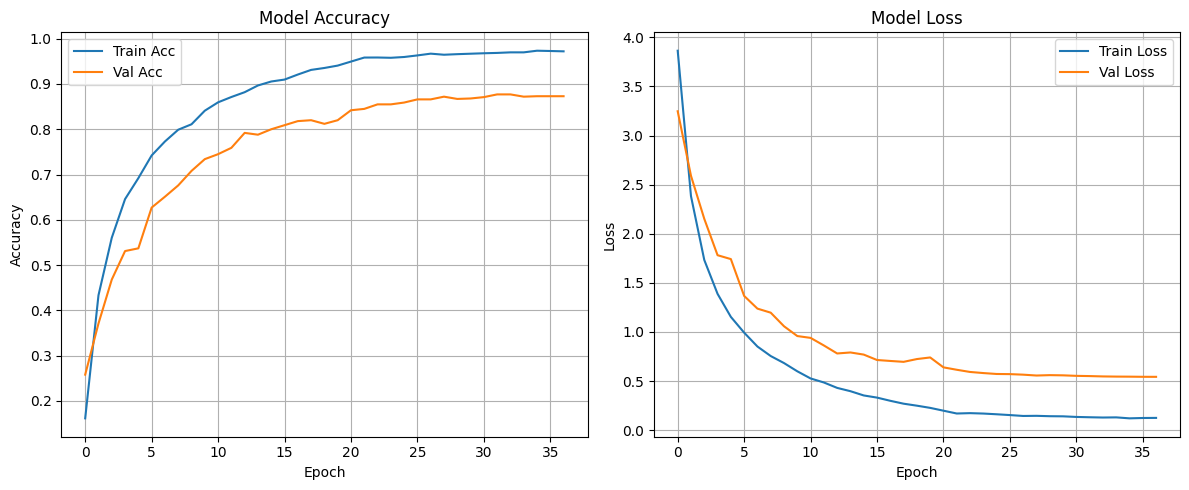

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Akurasi
axs[0].plot(history.history['accuracy'], label='Train Acc')
axs[0].plot(history.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Plot Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Val Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Menampilkan plot
plt.tight_layout()
plt.show()



**Grafik Kiri – Model Accuracy**

Grafik ini memperlihatkan perkembangan akurasi model pada data pelatihan (*Train Acc*) dan validasi (*Val Acc*) selama **37 epoch**.

* Akurasi pelatihan meningkat tajam dari sekitar 20% dan mencapai **97.52%** di epoch ke-37.
* Akurasi validasi juga meningkat secara signifikan hingga **87.30%**, lalu stabil.
* Gap antara akurasi training dan validation tidak terlalu jauh, mengindikasikan generalisasi model cukup baik tanpa overfitting.

**Grafik Kanan – Model Loss**

Grafik ini menggambarkan penurunan nilai loss sebagai indikator kesalahan prediksi model:

* *Training loss* menurun tajam dari hampir 4.0 menjadi **0.1225**.
* *Validation loss* juga turun dari angka di atas 3.0 menjadi **0.5431**.
* Kedua kurva loss menurun dengan konsisten tanpa fluktuasi ekstrem.

**Kesimpulan**

* Akurasi tinggi, stabil, dan konsisten di training maupun validation.
* Kurva loss menurun dengan baik tanpa tanda overfitting.
* Hasil ini menandakan model cukup andal dalam mengklasifikasikan **100 kelas tanaman herbal lokal** secara visual.


In [ ]:
test_loss, test_acc = model.evaluate(test_datagen, verbose=0)

print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

Test Loss     : 0.5424
Test Accuracy : 0.8700




* **Test Loss: 0.5424**
  Nilai ini menunjukkan rata-rata kesalahan model dalam memprediksi data uji. Angka yang rendah menandakan bahwa model dapat mengenali pola dengan baik bahkan di luar data pelatihan.

* **Test Accuracy: 87.00%**
  Artinya, model berhasil mengklasifikasikan **87 dari setiap 100 gambar tanaman herbal** dengan benar pada data uji. Ini konsisten dengan akurasi validasi sebelumnya (87.30%), menandakan performa model stabil dan tidak overfitting.




## Inference

Saving images (1).jpeg to images (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


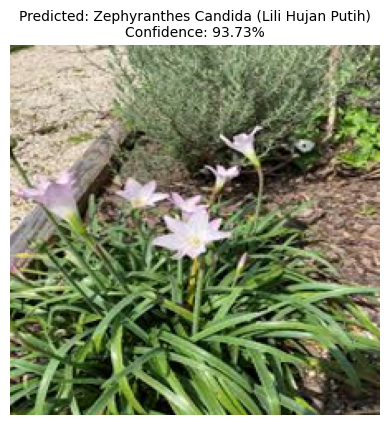

In [ ]:
# Upload gambar
from google.colab import files
import io
uploaded = files.upload()

for file_binary in uploaded.values():
    img = Image.open(io.BytesIO(file_binary)).convert('RGB')
    img = img.resize((224, 224))

    # Preprocess
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_index]
    confidence = prediction[0][predicted_index] * 100

    # Tampilkan
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=10)
    plt.axis('off')
    plt.show()

Model menerima input berupa gambar tanaman dan memberikan hasil prediksi bahwa gambar tersebut adalah Zephyranthes Candida (Lili Hujan Putih) dengan tingkat keyakinan (confidence) sebesar 93.73%.
Hal ini menunjukkan bahwa model berhasil mengidentifikasi gambar dengan tingkat akurasi yang tinggi, meskipun gambar diambil dari lluar dataset pelatihan. Hal ini membuktikan bahwa model memiliki kemampuan generalisasi yang baik dan dapat digunakan dalam situasi dunia nyata misalnya oleh pelajar untuk mengidentifikasi tanaman langsung dari lingkungan sekitar.

## Konversi Model

Pada tahap terakhir dilakukan konversi model dari format `.h5` ke format TensorFlow\.js menggunakan `tensorflowjs_converter`. Konversi ini memungkinkan model dijalankan langsung di browser tanpa server, sehingga bisa diintegrasikan ke dalam aplikasi berbasis web (PWA) seperti HerbPlants. File hasil konversi kemudian diunduh dalam bentuk `.zip` agar siap digunakan oleh tim frontend.

In [ ]:
model.build((None, 224, 224, 3))
model.save('/content/Model/model.h5')

!tensorflowjs_converter --input_format=keras /content/Model/model.h5 /content/Model/tfjs_model

# Unduh file .h5
from google.colab import files
files.download('/content/Model/model.h5')

# Zip model TF.js dan download
!zip -r tfjs_model.zip /content/Model/tfjs_model
files.download('tfjs_model.zip')


2025-06-11 15:44:58.673430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749656698.698645    6520 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749656698.705500    6520 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Model/tfjs_model/ (stored 0%)
  adding: content/Model/tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: content/Model/tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: content/Model/tfjs_model/model.json (deflated 96%)
  adding: content/Model/tfjs_model/group1-shard1of3.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip freeze > requirements.txt

In [ ]:
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>